# Community Citation Analysis 

Making use of a community citation analysis to identify groups/communities in the behavious of works citing each other.

In [1]:
#import necessary packages
import networkx as nx
import numpy as np
from community import community_louvain #pip install python-louvain package
import leidenalg as la
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt

## Read the data

Read the data generated by get_data_openalex.ipynb notebook.

In [2]:
# Load the data
#data_file = '../data/openAlex/test/pub2ref.csv'
data_file = '../data/fake/citation_data_fake.csv'
citation_data = pd.read_csv(data_file)

In [3]:
print("Information of the data being used:")
print()
citation_data.info()
print()
print(citation_data.head(20))

Information of the data being used:

<class 'pandas.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   paper_name  138 non-null    str  
 1   source      138 non-null    str  
 2   target      138 non-null    str  
dtypes: str(3)
memory usage: 9.5 KB

   paper_name               source               target
0     Paper 1  WOS:000279731700007  WOS:000279731700009
1     Paper 1  WOS:000279731700007  WOS:000396401600013
2     Paper 1  WOS:000279731700007  WOS:000365063100009
3     Paper 1  WOS:000279731700007  WOS:001265701800001
4     Paper 1  WOS:000279731700007  WOS:000587608600026
5     Paper 1  WOS:000279731700007  WOS:000492417900009
6     Paper 1  WOS:000279731700007  WOS:000380450900007
7     Paper 1  WOS:000279731700007  WOS:001336892600004
8     Paper 2  WOS:000365063100009  WOS:000279731700007
9     Paper 2  WOS:000365063100009  WOS:001336892600004
10    Paper 2  WOS:000

## Perform the community analysis

Makes use [networkx](https://networkx.org/documentation/stable/) package, [igraph](https://python.igraph.org/en/stable/) package.

A `Graph` is a collection of nodes (in this case, works) and edges (in this case lines representing citations between works). Should identify pairs of nodes (i.e., in this case, two works that have a citation link between them). We are using OpenAlex IDs to define nodes in this example. Our tables are effectively a long list of edges because we have created a list of every pair of citations (sources and targets or publication_ids and reference_ids). So we use the citation_data to add all of these edges to the Graph.

With `iGraph` object, we can do fast manipulation and analysis. [`ig.Graph.TupleList`](https://python.igraph.org/en/main/api/igraph.Graph.html#TupleList) constructs a graph for a list of tuples (which is what we had in out `Graph`. We have set directed=True, which I think keeps track of the direction of the edge (i.e., which is the citing and which is the cited work in this case).

In [6]:
# Create a directed graph
G_networkX = nx.DiGraph() #create an empty graph
#G_networkX.add_edges_from(citation_data[['publication_id', 'reference_id']].values) #create the edges
G_networkX.add_edges_from(citation_data[['source', 'target']].values)

# Convert the NetworkX graph to an iGraph object
g_iGraph = ig.Graph.TupleList(G_networkX.edges(), directed=True)

## Perform the partition

Uses the [leidenalg](https://leidenalg.readthedocs.io/en/stable/intro.html) package.

In [7]:
# Perform Leiden community detection (note the number of iterations is how many times the algorithm is used, if make it negative then runs until not improvement)
partition = la.find_partition(g_iGraph, la.ModularityVertexPartition, n_iterations=-2)

# Get the community assignments
community_ids = partition.membership

In [18]:
#Print overview of communities identied
print("")
print("----Partition Overview----")
print("Number of unique papers across all edges (i.e., citation links):",len(community_ids))
print("Number of communities (N.B. community ids are indexed form 0):",max(community_ids)+1)
print("")


----Partition Overview----
Number of unique papers across all edges (i.e., citation links): 26
Number of communities (N.B. community ids are indexed form 0): 5



## Get community metrics and print results data

In [11]:
# Create a dictionary mapping nodes to community IDs
node_community = {node: community_id for node, community_id in zip(G_networkX.nodes(), community_ids)}

# Calculate community metrics (e.g., size, density)
community_metrics = {}
for community_id in set(community_ids):
    #get number of papers (nodes) in each community
    community_nodes = [node for node, cid in node_community.items() if cid == community_id]
    #get density in each node [what is this?!?!]
    community_graph = G_networkX.subgraph(community_nodes)
    community_metrics[community_id] = {
        'size': len(community_nodes),
        'density': nx.density(community_graph)
    }

# Print community metrics (number of papers in each community and the density)
for community_id, metrics in community_metrics.items():
    print(f"Community {community_id}: size={metrics['size']}, density={metrics['density']}")
print("-------------")
print("")

Community 0: size=7, density=0.9761904761904762
Community 1: size=6, density=0.13333333333333333
Community 2: size=5, density=0.3
Community 3: size=4, density=0.25
Community 4: size=4, density=0.5
-------------



<h1>Make figure</h1>

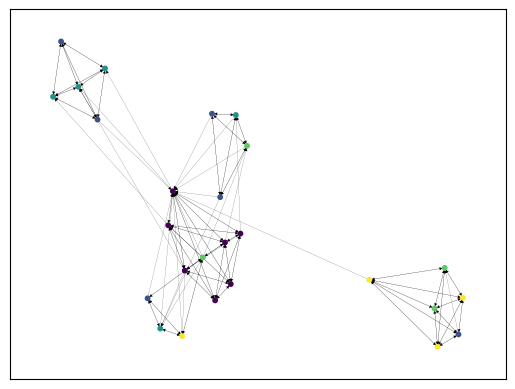

In [14]:
#here would like to obtain the number of edges to each node and size the nodes by this

# Sort out colors to match the community IDs ***not working**
colors = [community_ids]
print("")
#print(colors)
    

#Plotting options
options = {
    'node_size': 10,
    'width': 0.1,
    'arrowsize': 5,
    'with_labels': False
}

nx.draw_networkx(G_networkX, pos = nx.spring_layout(G_networkX), node_color=colors, cmap='viridis', **options)

plt.savefig("../output/figures/output.png",dpi=300)
plt.show()